## Multiseeding Pattern Simulator
#### Author: Yasa Baig

In this notebook, we generate a python implementation of Luo et. al (2020)'s paper on coarse-grained optimal bacterial growth simulator. Unlike mechanistic RD models, this system operates by assuming that whatever geometry is generated by numerics is simply the one which maximizes global population biomass accumulation. This is done in practice by running a mixed agent-based, PDE simulation where the diffusion of nutrients is handled via a PDE but the actual growth of the colony is done through an agent based method where individual "tips" of branches are tracked and grow (i.e. move in space) and subdivide according to some fixed rules in the system. 

In this notebook, we generalize the initial python script to handle systems with multiple initial seeding locations. The modifications require that we handle the fact that we need to consider the fact that now we multiple seeding configurations, different colonies will distribute nutrients internally, i.e. each branch will accumulate biomass proportional to their total intake on a given timestep. This requires us to generalize the previously static $dE$ energy intake to a vector quantity as we can no longer rely on the symmetry or rapid diff

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scienceplots

# Make my plots pretty!
plt.style.use(['science','no-latex'])

We begin by defining parameters for our system simulation. For now we just leverage the same numerical parameters used by Nan in the original paper. 

In [2]:
# First define the system's baked in parameters for width and density, these two are the two major geometrical bifurcation parameters which will get
# mapped to some final biomass accumulation score function. 

width = 3.0# The average width of a branch in the system
density = 0.2 # The average branch density of the system

# Define additionally the initial nutrient concentration for the system and the cellular movement efficiency, these are experimentally preset in a system
# and also correspond to the major bifurcation parameters which can be varied experimentally via CasAmino acid density or agar density. 

N0 = 8 # Initial uniform nutrient concentration of the sytem
gamma = 7.5 # The constant colony expansion efficiency; a measure of how much energy is needed to extend a branch basically

Now the the chief bifurcation parameters of the system have been developed, we next consider the system's domain parameters, i.e. the dimension and FD discretization of the petri dish of interest. 

In [3]:
# We use the original non-dimensionalized parameters of the system

L = 90 # DEFAULT 90 Grid length
totalT = 48 # Simulation time length

dt = 0.02 # Integration time step
nt = totalT/dt # Number of time steps

nx = 1000
ny = 1000 # Number of grid points
dx = L / (nx-1) # Grid spacing
dy = dx # Grid spacing

# Create a FD grid
x = np.linspace(-L/2, L/2, nx)
y = np.linspace(-L/2, L/2, ny)
XX, YY = np.meshgrid( x, y)


Now that the geometric and biological constants of interest have been setup and the basic grid created we will now setup our simulation. For this, we need to keep track of three major variables: the cell density $C(x,y)$, the nutrient density $N(x,y)$, and a utility variable known as the pattern density $P(x,y)$ which is simply used to track the spatial profile expansion of the system in space under uniform conditions. 

In [4]:
C = np.zeros((nx, ny))
P = np.zeros((nx, ny))
N = np.zeros((nx, ny)) + N0

Now we define the initial conditions of the simulation. We will generate our colony starting from a circular innoculation point. In later scripts, we can generalize this to more complex initial geometries, but we'll stick with this for now. 

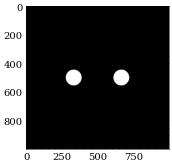

In [5]:
r0 = 5.0 # Initial radius of our colony inocculation point
c0 = 2000.0 # Initial total number of cells in our system measured in a.u.  DEFAULT: 0.5


offset = 15.0 

# For convenience, define a radial position grid as well
RR = np.sqrt( (XX - offset) **2 + YY**2)
P[RR < r0] = 1
RR = np.sqrt( (XX + offset) **2 + (YY) **2)
P[RR < r0] = 1


C[P == 1] = c0/( np.sum(P) * nx * ny)
C_pre = C;

# Plot initial conditions for effect
plt.imshow(C*P, cmap = "gray")
plt.show()

Here we now define the beggining of the agent based component of the simulation. The basic idea of how this simulation works is that for each branch we track the location of the tip $\boldsymbol{r}_i = (x_i, y_i)$ and change this as a branch grows (i.e. $r_i$ increments in total magnitude) or bifurcates (new agents are added to the model. We track exactly two coordinates per branch and thus overall we have a $ 2 \times k$ matrix to track all of these where $k$ varies throughout the course of the model simulation. 

At the beggining of the simulation the number of branches $k$ is determined by the density parameter such that for a density of $D$ we want to have $2 \, \pi \, r_0 \, D$ initial branches with at least $2$ minimum branches. 

In [6]:
ntips0 = np.round(2 * np.pi * r0 * density) # Calculate the total initial number of tips in the system
ntips0 = max(ntips0, 2) # Threshold such that we always have 2 tips
ntips0 = int(ntips0) # Cast to an integer for later usage
ntips0

6

Now we'll create vectors to store the $x$ and $y$ position of the tip agents as well as $\theta_i$ variables to track in what directions they will extend. Each agent thus effectively has a position and a velocity vector, but the velocity magnitude, $\dfrac{dL_i}{dt}$ is tied to the total biomass accumulation. 

In [7]:
rX_1 = np.zeros(ntips0) - offset
rY_1 = np.zeros(ntips0)

rX_2 = np.zeros(ntips0) + offset
rY_2 = np.zeros(ntips0) 

rX = np.hstack( [rX_1, rX_2])
rY = np.hstack([rY_1, rY_2])


# While we are here, compute the total biomass of the system
biomass = np.sum(C*dx*dy)

theta = np.linspace( np.pi/2 , np.pi/2 + 2*np.pi  , ntips0 + 1) # Initial positions will be radially symmetric with respect to the initial innoculation. By
# symmetry this is the best strategy to ensure that nutrients are well distributed for a uniform background nutrient concentration 
theta = theta[:-1]

theta = np.hstack( [theta, theta])

# The above step just drops teh final theta angle since it's just a repeat of the first point by periodicitt

Let's quickly visualize the initial position of these branch expansion points:

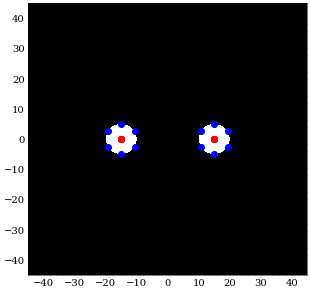

In [8]:
rX_ex = r0*np.cos(theta)
rY_ex = r0*np.sin(theta)

plt.figure(figsize = (5,5))
plt.pcolormesh(XX,YY, P, cmap = "gray", shading = "nearest")
plt.xlim(-L/2, L/2)
plt.ylim(-L/2, L/2)
plt.scatter(rX , rY , color = "red")
plt.scatter(rX + r0*np.cos(theta), rY + r0*np.sin(theta), color = "blue")
plt.show()

#### Branching Domains

To handle **multiseeding simulations** we need to be able to break up different initial swarms by the biomass they can uptake since now branches can overlap and swarms should not be able to exchange nutrients. To this end we store a $n_x \times n_y \times n_{tips}$ tensor which stores a boolean matrix for each tip that indicate what region of the swarm it can pull from. We then, in simulation, will distribute biomass equally among all branches which co-overlap at a location. 

In [9]:
# Generate the the branching tensor
ntips = rX.shape[0]
branch_domain = np.zeros( (nx, ny, ntips) )

# Now we go through each tip and initialize the starting domains equal to the original swarming blots
for k in range(ntips):
    
    # For now, we'll let the non-connecting swarms to overlap, it is easy to partition these into two different domains later. 
    branch_domain[:,:,k] = (C > 0)
    
    

Furtheremore, since now the local biomass associated to each tip leads to local expansion of the tip, the $dE$ and $dl$ generated from biomass uptake now varies from branch to branch as well. 

In [10]:
dE = np.zeros(ntips)
dl = np.zeros(ntips)

### Modeling Dynamics

We now will consider actually simulating the system. Our hybrid PDE-agent based model evolves according to the following steps. 

First, we model nutrients undergoing diffusion in space and consumption by cells. This is given by the simple reaction-diffusion equation:

$$
\dfrac{\partial N}{\partial t} = D_N \, \nabla^2 N - \beta_N \, f_g(\boldsymbol{x})
$$

Where $D_N$ is the diffusion constant of the nutrient (for small molecules on order of 2000 to 200 $\mu m/s^2$, $\beta$ is the uptake rate and $f_g$ corresponds to a consumption function for the cells and varies in space depending on local cell density concentration. The nutrient obeys no flux conditions. 
Next we consider the growth of cells throughout the pattern. We operate under the simplifying assumption that the diffusion of biomass throughout the entire colony is very fast relative to consumption and that biomass is allocated uniformly (for now) throughout the pattern. Thus we treat biomass purely as a scalar quantity. 

$$
\dfrac{d C}{dt} = \dfrac{\int_{\Omega} \, \alpha_c \, f_g(\boldsymbol{x}) \, d\boldsymbol{x}  }{\int_{\Omega} \, d\boldsymbol{x} }
$$

Thus the biomass is computed by taking the integral of nutrient consumption over the entire space and then distributing equally over the entire volume, leading to a scalar cell density. This treats the explicitly continuous part of the model. Next we need to consider the agent based component of this model, which is more nontrivial. For each individual branch we compute the extension (i.e. $\partial_t L_i$ or numerically $\Delta r_i$). This leads to extension given by:

$$
\frac{\mathrm{d} L_i}{\mathrm{~d} t}=\frac{\gamma}{W_i} \int_{\Omega_i} \frac{1}{n} \alpha_C f_G \mathrm{~d} \boldsymbol{x}
$$

Where $\gamma$ is the expansion efficiency, a mechanical constant, and $W_i$ is the width of a given branch. $\alpha$ in turn controls the relative energy translation effiency from nutrient uptake in the system. The $n$ here corresponds to the number of branches (agents) which overlap at a given location in space. The integral is taken over the branch $\Omega_i$. Lastly we need to define this ever important consumption function, which is given by simple Michealis-Menton kinetics:

$$
f_G(x,y) =\frac{N(x,y)}{N(x,y)+K_N} \frac{C_m}{C(x,y)+C_m} C(x,y)
$$

We define the kinetic constants (estimated from pure liquid culture experiment) below. 

We proceed by explicit Euler 1st order timestepping for most of these terms save for nutrient diffusion, which we explain below.


In [11]:
bN = 160 # beta uptake constant
DN = 9; # Diffusion constant 
aC = 1.2; # alpha elongation efficiency constant
KN = 0.8; # half saturation for nutrient uptake kinetcs
Cm = 0.05; # Half saturation for cell density in monod model. 

#### Diffusion Diatribe

We are now ready to run the simulation. However, first we need to specify a numerical scheme to handle the diffusion PDE of our system. We will leverage an approximation to the 2D Crank-Nicholson scheme for computing the solution. 

To review numerical background recall the Crank-Nicholson method or trapezoid rules solve the diffusion equation via taking an average of the explicit and implicit finite center differences: 

$$
\frac{u_i^{n+1}-u_i^n}{\Delta t}=\frac{a}{2(\Delta x)^2}\left[\left(u_{i+1, j}^{n+1}+u_{i-1, j}^{n+1}+u_{i, j+1}^{n+1}+u_{i, j-1}^{n+1}-4 u_i^{n+1}\right)+\left(u_{i+1, j}^n+u_{i-1, j}^n+u_{i, j+1}^n+u_{i, j-1}^n-4 u_i^n\right)\right]
$$

Letting $\mu = a \Delta t/ (\Delta x)^2$ this yields the following linear equation in $N \times N$ variables:

$$
(1+2 \mu) u_{i, j}^{n+1}-\frac{\mu}{2}\left(u_{i+1, j}^{n+1}+u_{i-1, j}^{n+1}+u_{i, j+1}^{n+1}+u_{i, j-1}^{n+1}\right)=(1-2 \mu) u_{i, j}^n+\frac{\mu}{2}\left(u_{i+1, j}^n+u_{i-1, j}^n+u_{i, j+1}^n+u_{i, j-1}^n\right)
$$

On the left hand side we have isolated all variables associated to the next time point $u^{t+1}_{i,j}$ as an implict function of its local points. On the right hand side, similarly we have all the variables assocated to the current time point. This equation is purely linear in all of its arguments and thus can be solved analytically but very unfun to solve generally. This equation, however, can be nicely rewritten as following. Define the linear operators:

$$
\delta_x^2 f_{i, j}=f_{i+1, j}-2 f_{i, j}+f_{i-1, j} \quad \delta_y^2 f=f_{i, j+1}-2 f_{i, j}+f_{i, j-1}
$$

This allows us to rewrite our entire system in a nicer compact form:

$$
\left(1-\frac{\mu}{2} \delta_x^2-\frac{\mu}{2} \delta_y^2\right) u_{i, j}^{n+1}=\left(1+\frac{\mu}{2} \delta_x^2+\frac{\mu}{2} \delta_y^2\right) u_{i, j}^n
$$

This, however, still varies in $x$ and $y$ variables jointly, and we'd prefer to be able to solve two 1D equations. For this, we can leverage a simple approximation using the fact that $\mu$ is small. Consider the following related equation:

$$
\left(1-\frac{\mu}{2} \delta_x^2\right)\left(1-\frac{\mu}{2} \delta_y^2\right) u_{i, j}^{n+1}=\left(1+\frac{\mu}{2} \delta_x^2\right)\left(1+\frac{\mu}{2} \delta_y^2\right) u_{i, j}^n
$$

This is equivalent to the prior full equation in the limit of $O(\mu^2)$ terms being negligible:

$$
\left(1-\frac{\mu}{2} \delta_x^2-\frac{\mu}{2} \delta_y^2+\frac{\mu}{2} \delta^2 \frac{\mu}{2} \delta_x^2\right) u_{i, j}^{n+1}=\left(1+\frac{\mu}{2} \delta_x^2+\frac{\mu}{2} \delta_y^2+\frac{\mu}{2} \delta^2 \frac{\mu}{2} \delta_x^2\right) u_{i, j}^n
$$

These equations can now be factorized into the much simpler scheme which requires only one to solve two 1D linear problems:

$$
\begin{aligned}
\left(1-\frac{\mu}{2} \delta_x^2\right) u_{i, j}^* & =\left(1+\frac{\mu}{2} \delta_y^2\right) u_{i, j}^n \\
\left(1-\frac{\mu}{2} \delta_y^2\right) u_{i, j}^{n+1} & =\left(1+\frac{\mu}{2} \delta_x^2\right) u_{i, j}^*
\end{aligned}
$$

Thus we need to now solve two linear problems in the variables of interest in the system. Very nicely, these can be expressed in terms of matrix-matrix products on the finite difference matrix $N[i,j]$:

$$
\begin{aligned}
V_1 \, N^* &= N_T \, U_1 \\
N_{T+1} \, U_2 &= V_2 \, N^*
\end{aligned}
$$

Note here the left vs right multiply is determined by whether the matrix operates on the $x$ or $y$ direction. Now to update time we just need to just solve both of these equations iteratively. Below we define a function to generate these matrices: 

In [12]:
def diff(dx, dy, nx, ny, dt, D):
    
    # First compute the assocatiated mu terms in both directions
    mu_x = D*dt/(dx**2)
    mu_y = D*dt/(dy**2)

    # Now compute the central difference operators
    Ix = np.eye(nx)
    Iy = np.eye(ny)

    P = np.diagflat(np.ones(nx)) * -2
    P2 = np.eye(nx, k = 1)
    P3 = np.eye(nx, k = -1)

    Q = np.diagflat(np.ones(ny)) * -2
    Q2 = np.eye(ny, k = 1)
    Q3 = np.eye(ny, k = -1)

    Mx = P + P2 + P3
    My = Q + Q2 + Q3

    # Impose no flux boundary conditions for the system
    Mx[0,1] = 2
    Mx[nx - 1, nx - 2] = 2
    My[1, 0] = 2
    My[ny - 2, ny - 1] = 2
     
    # Lastly, define the four major operators used to solve our two coupled 1D problems
    V1 = Ix - mu_x / 2 * Mx
    V2 = Ix + mu_x / 2 * Mx
    U2 = Iy - mu_y / 2 * My
    U1 = Iy + mu_y / 2 * My 
    
    return V1, V2, U1, U2

Derive our total linear operators for our system:

In [13]:
V1, V2, U1, U2 = diff(dx, dy, nx, ny, dt, DN)

Now we are prepared to simulate the system. To handle the reaction component of our system, we leverage operator splitting to simulate the reaction initially (which we treat occurs very fast) and then diffusion second: 

In [14]:
# Change to false if we do not want to plot the intermediate patterns as they are generated
plot_intermediate = False

In [15]:
from tqdm.notebook import trange
from scipy.interpolate import RectBivariateSpline
from IPython.display import clear_output
import time

plt.figure(figsize = (6,6))

# Store the pattern values through time to play them all back in the end
pattern_store = []
nutrient_store = []
biomass_store = []


diffusion_times = []
bifurcation_times = []
branching_times = []

for i in trange(0, int(nt) ):
    
    # ----------- First calculate the nutrient dynamics and increase in cell density ------------- #
    
    start = time.time()
    
    # Compute fN(x,y) across the entire 2D field. 
    fN = N / (N + KN) * Cm / (C + Cm) * C
    
    # Compute the nutrient loss due to consumption as a function of space
    dN = -bN*fN
    
    # Compute the nutrient loss in space due to consumption 
    N = N + dN*dt;
    
    # Simulate the diffusion of nutrient in space via approximate CN scheme. Recall @ defines matrix-matrix multiplication. 
    Nstar = np.linalg.inv( V1 ) @ ( N @ U1 ) # Solve equation one to get an intermediate solution
    N = ( V2 @ Nstar ) @ np.linalg.inv( U2 ) # Solve equation two to get the final update
    
    # Now treat the gain in cell density, this is just an ODE solved via first order Euler explicit. 
    dC = aC * fN
    C = C + dC*dt
    
    stop = time.time()
    diffusion_times.append(stop - start)
    
    # -----------                      Branch extension and bifurcation.             ------------- #
    
    # Calculate the number of tips
    ntips = rX.shape[0]

    
    # Only consider branch extension bifurcation every 25 time points. These does not change the outcome and saves computation time 
    # per iteration of the outer loop. 
    if i % (0.2/dt) == 0:
        
        # --------------- MULTISEEDING COMPUTATION ---------------- #
        
        dBiomass = (C - C_pre)*dx*dy # Compute the total gain in biomass per unit cell in the underlying grid
        print(np.sum(dBiomass))
        print(C.max())
        
        # Now we have to compute the total number of branches which overlap at each point (x,y) in the underlying grid
        branch_domain_sum = np.sum( branch_domain, 2) # Sum along the third dimension of the tensor to get a map of the number of branches
        ntips = rX.shape[0]
        
        dE = np.ones(ntips)
        
        # Now we traverse each tip and compute the energy uptake to each of the individual tips
        for k in range(ntips):
            
            
            branchfract = 1 / (branch_domain_sum * branch_domain[:,:,k])
            
            # Let all infinity term to zero
            branchfract[ branchfract > 1 ] = 0
            
            #print(np.max(dBiomass))
            #print(np.max(branchfract))
            
            # Compute the energy uptake per tip. Calculated by distributing energy proportional to the number tips at a given location
            dE[k] = np.sum( dBiomass * branchfract )
            
        # Convert the energy uptake to length extension
        dl = gamma*dE/width;    
        
        # For the first branch, we just set this value for extension hard-codedly
        if i == 0:
            dl = 0.5*np.ones(ntips)
        
        ### BIFURCATION ###
        
        # Now we will consider branch bifurcation. We bifurcate an end point in the case that that that endpoint's distance to another
        # endpoint exceeds some distance threshold defined by the density of the system. We use that cutoff to be 2/3 D so that at most
        # the density of bifurcations of the system only vary between 2/3 D and 4/3 D (recall branching generates two endspoints, i.e. 
        # doubles the density of the system), such that on average the variation of the density in the system only varies 33% from the
        # mean density D. 
        
        start = time.time()
        
        # Compute the critical density radius
        R = 1.5 / density
        
        # Create some varialbes to store the new locations of the tips 
        rX_new = rX
        rY_new = rY
        theta_new = theta
        branch_domain_new = branch_domain
        dl_new = dl
        
        # Now we iterate through each individual branch in our system and bifurcate our new branch IF the density criterion is met
        for k in range(ntips):
            
            # Compute the distance of the current tip to all other tips in the system
            dist_sq = (rX_new - rX[k])**2 + (rY_new - rY[k])**2
            
            # Sort the distances
            dist_sq = np.sort(dist_sq)
            
            # Now if the second largest element in the list, i.e. the closest tip, exceeds the distance threshold, then we bifurcate. 
            if dist_sq[1] > R**2:
                
                # print("BIFURCATING!")
                
                # Append a new tip to the list located at 45 degree angles from the bifurcation point
                rX_new = np.append(rX_new, rX[k] + dl[k]*np.sin(theta[k] + 0.5 * np.pi))
                rY_new = np.append(rY_new, rY[k] + dl[k]*np.cos(theta[k] + 0.5 * np.pi))
                
                # For the second branch, we just commondere the "current" branch and just have it grow in the 45 degree of the
                # the opposite direction. IE numerically we don't consider this a process of a single branch dying and then
                # two new ones growing from it like a hydra, rather one branch starts to curve and the other branch splits 
                # off from it at the deflection angle of 90 degrees. 
                
                rX_new[k] = rX_new[k] + dl[k]*np.sin(theta[k] - 0.5*np.pi)
                rY_new[k] = rY_new[k] + dl[k]*np.cos(theta[k] - 0.5*np.pi)
                
                # Lastly, append a new angle to the theta vector which corresponds to the new branch that we added. We will
                # for now use just use a dummy value, we'll go ahead and set the bifurcation direction in the later steps 
                # of the numerics. 
                theta_new = np.append(theta_new, theta[k])
                
                # Update the branching domain for the new tip by copying the parent tip as the domains for the new tip, concatenating
                # along the third dimension. 
                branch_domain_new = np.append( branch_domain_new, np.expand_dims( branch_domain_new[:,:,k], 2 ), 2 )
                
                # Update the energy vector, splitting the total amount of length extension in half between the two tips
                dl_new[k] = dl_new[k]/2
                dl_new = np.append( dl_new, dl_new[k]/2 )

                
        # With all of the bifurcations handled, we now can safely update the running agent positons
        rX = rX_new
        rY = rY_new
        theta = theta_new
        ntips = rX.shape[0]
        branch_domain = branch_domain_new
        dl = dl_new
        
        end = time.time()
        
        bifurcation_times.append(start - end)
        
        #### BRANCH EXTENSION
        
        start = time.time()
        
        # Store a previous version of the agent location before update; we'll use this to handle terminaing the growth 
        # of a branch at maximal distance. 
        rX_pre = rX;
        rY_pre = rY;
        
        # If this is the first step, just grow the branches from the current position by the hard-coded initial dl
        if i == 0:
            
            dl = 0.5*np.ones(ntips)
            
        else:
            
            # Okay, so to predict tip extension we need to predict the direction of growth for each tip. To this end we 
            # proceed in the following procedure. For each tip we consider a local circular region around it with radius
            # equal to dl. We sample ~200 points on this circle at equal intervals and for each point, interpolate
            # the local nutrient concentration. The branch then will extend in the direction of the most nutrient on this circle.
            # Thus we are assuming that branches basically are advected in the direction of \Nab N which is maximal. 
            
            # First we need to generate, for each tip, a sample of points on a cirlce which are dL from the center. We use
            # the delta vector to specify the 200 points on this circle. 
            delta = np.pi*np.linspace(-1,1,200)
            
            # Now for each tip we create a matrix which is ntips x delta.shape[0], where each row corresponds to 
            # angle samples around the point.
            theta0 = np.tile(delta, (ntips, 1))
            
            
            # Now consider the points on a circle dl away radiating out from our delta angles
            x_candidates = rX + dl[k]*np.sin(theta0).T
            y_candidates = rY + dl[k]*np.cos(theta0).T
            
            # Now we interpolate the value of the nturient concentration at each of these points. We do this by first fitting a bivariate
            # spline to the current nutrient concentration and then interpolating at our points of interests. 
            interp = RectBivariateSpline(x, y, N.T)
            
            
            # Evaluate at desired points
            N_int = interp.ev(x_candidates, y_candidates)
            
            # Now for each agent, and thus each row in the interpolated matrix, we pick the direction which maximizes the nutrient concentration
            # concentration. We thus need to compute the argmax for each row, i.e. the index at which nutrient is maximized. This can
            # be then used to look up the optimal directional angle in the next step. 
            
            # Find the maximal direction on the circle
            maxes = np.argmax(N_int, axis = 0)
            
            # Update the length of each tip as well as update the growth direction
            for k in range(ntips):
                rX[k] = x_candidates.T[k, maxes[k]]
                rY[k] = y_candidates.T[k, maxes[k]]
        
                theta[k] = theta0[k, maxes[k]] # + np.random.randn(0,1)*noise_amp OPTIONALLY ADD NOISE TO GROWTH DIRECTION
                
            # Now hard enforce the rule that the branches will terminate growing near the edges, here defined as 85% of the distance from
            # the edge of the simulation
            terminated_idx = np.sqrt( rX**2 + rY**2 ) > 0.65*L/2
            
            # Terminate early if teh simulation is complete
            if np.sum(terminated_idx) == ntips:
                print("EARLY TERMINATION")
                break
                
            for k in range(ntips):
                if terminated_idx[k]:
                    rX[k] = rX_pre[k]
                    rY[k] = rY_pre[k]
            
        stop = time.time()
        
        branching_times.append(stop - start)
        
        # Lastly fill the width of the branches of the simulations. This is just done by setting all the points within a width/2
        # radius of the tips to 1, indicating their are filled with biofilms.
        for k in range(ntips):
            d = np.sqrt( (XX-rX[k])**2 + (YY-rY[k])**2 )
            P[d <= width/2] = 1
            
            # Update the branching domains as needed. If this location already exists, then
            if branch_domain[:,:,k] is not None:
                branch_domain[:,:,k] = (branch_domain[:,:,k])
            else:
                branch_domain[:,:,k] = ( d <= width/2 )

        # Now simulate the very rapid diffusion of the cell biomass across the pattern
        C[P == 1] = np.sum(C)/( np.sum(P) * dx * dy) 
        C_pre = C;
        
        if plot_intermediate and (i%100 == 0):
            plt.figure(figsize = (6,6)) 


            # Now handle the plotting the simulation of the system
            plt.title(i)
            plt.pcolormesh(XX, YY, N)
            plt.scatter(rX, rY, zorder = 10, color = "red")
            plt.show()

            plt.figure(figsize = (6,6)) 


            # Now handle the plotting the simulation of the system
            plt.title(i)
            plt.pcolormesh(XX, YY, P, cmap = "gray" )
            plt.scatter(rX, rY, zorder = 10, color = "red")
            plt.show()
            
            # Clear the ipython output to enable teh next image to play. 
            clear_output(wait=True)
        
        # Store patterns throughout simulation to generate one final gif
        pattern_store.append( P.copy() )
        nutrient_store.append( N.copy() )
        biomass_store.append( C.copy() )

  0%|          | 0/2400 [00:00<?, ?it/s]

3.5416178276671945e-07
1.0582209368551613e-07


/var/folders/cy/286rxlsj5ksbn_qd610z9n9c0000gn/T/ipykernel_65045/351843847.py:68: RuntimeWarning: divide by zero encountered in true_divide
  branchfract = 1 / (branch_domain_sum * branch_domain[:,:,k])


0.000492152145651093
1.617825960521269e-05
0.07178282976891089
0.0024513603809497224
1.4606611560622622
0.31137390686577776
1.6732916853181758
38.37136706695358
1.647827724574283
4727.73318423816
1.617946026625444
582503.9918341758
1.585551009589555
71770316.80813941
1.550574094074015
8842820733.891682
1.4956124832602868
1089523942622.7394
0.0
134240244970547.7
0.0
1.6539740582821186e+16
0.0
2.0378614372093988e+18
0.0
2.5108490767857002e+20
0.0
3.0936171475076613e+22
0.0
3.8116456874441894e+24
0.0
4.6963286514999855e+26
0.0
5.786346531513134e+28
0.0
7.129357561477334e+30
0.0
8.784081451496224e+32
0.0
1.0822866756388498e+35
0.0
1.333485413054627e+37
0.0
1.6429873774246062e+39
0.0
2.024324747724857e+41
0.0
2.494170521671797e+43
0.0
3.0730674997518217e+45
0.0
3.78632646644422e+47
0.0
4.665132839305923e+49
0.0
5.747910171308826e+51
0.0
7.082000122069606e+53
0.0
8.72573235040196e+55


KeyboardInterrupt: 

<Figure size 432x432 with 0 Axes>

Play the pattern back. 

In [ ]:
biomass_store = np.array(biomass_store)
total_masses = np.sum(biomass_store, axis = (1,2))

In [ ]:
for i in range(0,len(pattern_store),1):
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1,4, figsize = (24,6))
    
    ax1.imshow(pattern_store[i], cmap = "viridis")
    ax1.set_title("Pattern")
    
    ax2.imshow(nutrient_store[i],vmin = 0, vmax = 8)
    ax2.set_title("Nutrient Concentration")
    
    ax3.plot( nutrient_store[i][200],)
    ax3.set_ylim(0,10.0)
    ax3.set_title("Nutrient Crosssection")
    
    ax4.plot( range(0,i, 1) , total_masses[0:i] )
    ax4.set_xlim( 0, len(pattern_store) )
    #ax4.set_ylim( 0, total_masses.max() )
    ax4.set_title("Total Biomass")
    plt.suptitle(f"Time = {i}")

    plt.show()
    
    clear_output(wait=True)

Store a video file:

In [ ]:
# from celluloid import Camera
# fig = plt.figure(figsize = (6,6))
# camera = Camera(fig)

# for el in pattern_store:

#     plt.imshow(el)
#     plt.xticks([])
#     plt.yticks([])
#     camera.snap()

In [ ]:
# animation = camera.animate()
# animation.save('test_pattern.gif')